In [ ]:
try:
    import networkx as nx
except:
    !pip install networkx matplotlib pandas
    import networkx as nx
import random, time, tracemalloc, heapq, os, json
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def measure(func, *args, **kwargs):
    tracemalloc.start()
    t0 = time.perf_counter()
    res = func(*args, **kwargs)
    t1 = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return {"result": res, "time": t1 - t0, "mem_peak_kb": peak / 1024.0}

def friend_suggestions_bfs(adj, user):
    from collections import deque
    visited = set([user])
    q = deque([(user,0)])
    direct = set(adj.get(user,[]))
    fof = {}
    while q:
        node, d = q.popleft()
        if d==2: continue
        for nb in adj.get(node,[]):
            if nb not in visited:
                visited.add(nb)
                q.append((nb,d+1))
        if d==1:
            for nb in adj.get(node,[]):
                if nb!=user and nb not in direct:
                    fof[nb] = fof.get(nb,0)+1
    sugg = sorted(fof.items(), key=lambda x:(-x[1],x[0]))
    return [x[0] for x in sugg]

In [ ]:
def bellman_ford(edges, V, src):
    dist = [float('inf')] * V
    dist[src] = 0
    for _ in range(V-1):
        changed = False
        for (u,v,w) in edges:
            if dist[u] != float('inf') and dist[u] + w < dist[v]:
                dist[v] = dist[u] + w
                changed = True
        if not changed:
            break
    neg_cycle = False
    for (u,v,w) in edges:
        if dist[u] != float('inf') and dist[u] + w < dist[v]:
            neg_cycle = True
            break
    return dist, neg_cycle

In [ ]:
def dijkstra(adj, src):
    dist = {node: float('inf') for node in adj}
    dist[src] = 0
    pq = [(0, src)]
    while pq:
        d,u = heapq.heappop(pq)
        if d>dist[u]: continue
        for v,w in adj[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                heapq.heappush(pq, (nd, v))
    return dist

In [ ]:
def prim_mst(adj, start=0):
    visited = set()
    pq = []
    total = 0
    edges = []
    visited.add(start)
    for v,w in adj[start]:
        heapq.heappush(pq, (w, start, v))
    while pq and len(visited) < len(adj):
        w,u,v = heapq.heappop(pq)
        if v in visited: continue
        visited.add(v)
        total += w
        edges.append((u,v,w))
        for nxv,nw in adj[v]:
            if nxv not in visited:
                heapq.heappush(pq, (nw, v, nxv))
    if len(visited) != len(adj):
        return None, []
    return total, edges

In [ ]:
def generate_random_graph_adj(n, p=0.1, weight_range=(1,20), directed=False, allow_negative=False):
    adj = {i: [] for i in range(n)}
    edges = []
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < p:
                w = random.randint(*weight_range)
                if allow_negative and random.random() < 0.15:
                    w = -random.randint(1, 10)
                adj[i].append((j,w))
                if directed:
                    edges.append((i,j,w))
                else:
                    adj[j].append((i,w))
                    edges.append((i,j,w))
    if directed:
        for i in range(n):
            for j in range(n):
                if i!=j and random.random() < (p/3):
                    w = random.randint(*weight_range)
                    if allow_negative and random.random() < 0.15:
                        w = -random.randint(1,10)
                    edges.append((i,j,w))
                    adj.setdefault(i,[]).append((j,w))
        for i in range(n):
            adj.setdefault(i,[])
    return adj, edges

sample_friend_adj = {
    "A": ["B","C"],
    "B": ["A","D","E"],
    "C": ["A","F"],
    "D": ["B","G"],
    "E": ["B","H","I"],
    "F": ["C","J"],
    "G": ["D"],
    "H": ["E"],
    "I": ["E"],
    "J": ["F"]
}
fs_out = friend_suggestions_bfs(sample_friend_adj, "A")
sample_edges_bf = [(0,1,5),(1,2,2),(0,2,10),(2,3,-8),(3,1,1)]
bf_res = bellman_ford(sample_edges_bf, 5, 0)
sample_adj_dij = {0: [(1,5),(2,10)], 1: [(0,5),(2,2)], 2: [(0,10),(1,2),(3,1)], 3: [(2,1)], 4: []}
dij_res = dijkstra(sample_adj_dij, 0)
sample_mst_adj = {0: [(1,4),(2,3)], 1: [(0,4),(2,5)], 2: [(0,3),(1,5),(3,2)], 3: [(2,2)]}
mst_res = prim_mst(sample_mst_adj, 0)
print("sample friend suggestions for A:", fs_out)
print("sample bellman-ford distances and neg cycle:", bf_res)
print("sample dijkstra distances:", dict(list(dij_res.items())[:10]))
print("sample prim mst total:", mst_res[0])

sample friend suggestions for A: ['D', 'E', 'F']
sample bellman-ford distances and neg cycle: ([0, -15, -8, -16, inf], True)
sample dijkstra distances: {0: 0, 1: 5, 2: 7, 3: 8, 4: inf}
sample prim mst total: 9


In [ ]:
sample_friend_adj = {
    "A": ["B","C"],
    "B": ["A","D","E"],
    "C": ["A","F"],
    "D": ["B","G"],
    "E": ["B","H","I"],
    "F": ["C","J"],
    "G": ["D"],
    "H": ["E"],
    "I": ["E"],
    "J": ["F"]
}

sample_edges_bf = [(0,1,5),(1,2,2),(0,2,10),(2,3,-8),(3,1,1)]

sample_adj_dij = {
    0: [(1,5),(2,10)],
    1: [(0,5),(2,2)],
    2: [(0,10),(1,2),(3,1)],
    3: [(2,1)],
    4: []
}

sample_mst_adj = {
    0: [(1,4),(2,3)],
    1: [(0,4),(2,5)],
    2: [(0,3),(1,5),(3,2)],
    3: [(2,2)]
}

In [ ]:
fs_out = friend_suggestions_bfs(sample_friend_adj, "A")
print("Friend Suggestions for A:", fs_out)

Friend Suggestions for A: ['D', 'E', 'F']


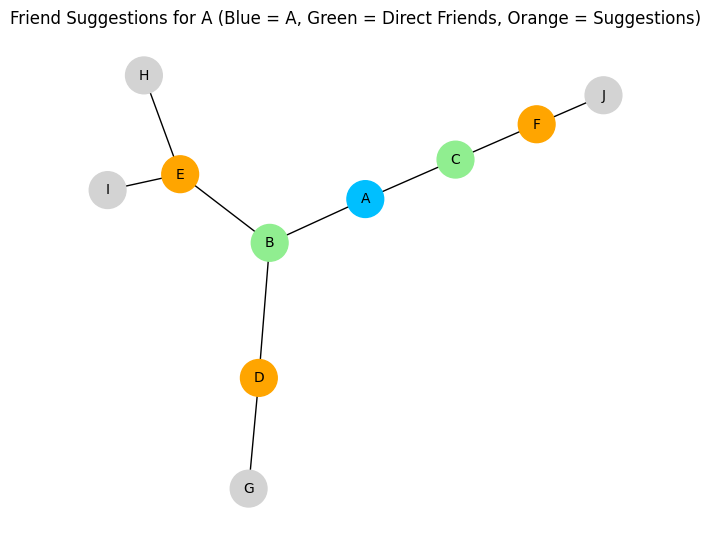

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for u, lst in sample_friend_adj.items():
    for v in lst:
        G.add_edge(u, v)

suggested = set(fs_out)
direct = set(sample_friend_adj["A"])
colors = []

for node in G.nodes():
    if node == "A":
        colors.append("deepskyblue")
    elif node in direct:
        colors.append("lightgreen")
    elif node in suggested:
        colors.append("orange")
    else:
        colors.append("lightgray")

plt.figure(figsize=(6,5))
pos = nx.spring_layout(G, seed=7)
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=700, font_size=10)
plt.title("Friend Suggestions for A (Blue = A, Green = Direct Friends, Orange = Suggestions)")
plt.show()

In [ ]:
bf_out = bellman_ford(sample_edges_bf, 5, 0)
print("Bellman-Ford Output:", bf_out)

Bellman-Ford Output: ([0, -15, -8, -16, inf], True)


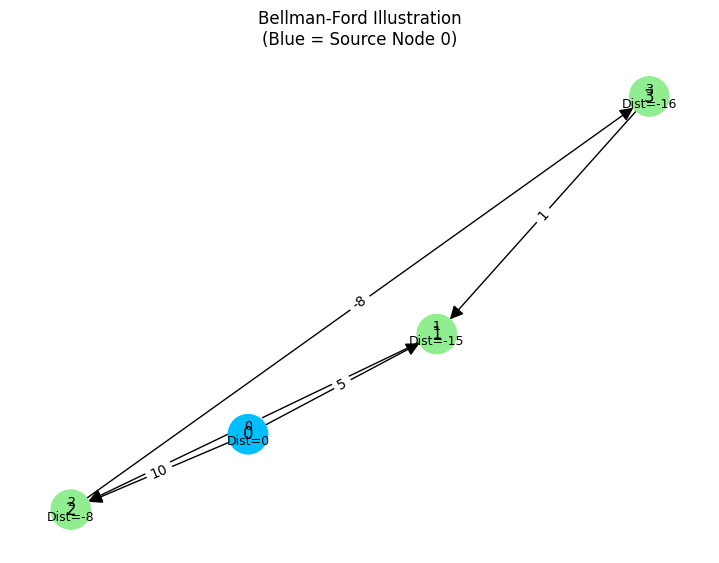

Negative Cycle Detected: True
Distances: [0, -15, -8, -16, inf]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

distances, neg_cycle = bf_out

G = nx.DiGraph()
for u, v, w in sample_edges_bf:
    G.add_edge(u, v, weight=w)

plt.figure(figsize=(7,5))
pos = nx.spring_layout(G, seed=10)

edge_labels = nx.get_edge_attributes(G, 'weight')

node_colors = []
for node in G.nodes():
    if node == 0:
        node_colors.append("deepskyblue")
    else:
        node_colors.append("lightgreen")

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

labels = {i: f"{i}\nDist={distances[i] if distances[i]!=float('inf') else '∞'}" for i in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=9)

plt.title("Bellman-Ford Illustration\n(Blue = Source Node 0)")
plt.show()

print("Negative Cycle Detected:", neg_cycle)
print("Distances:", distances)

In [ ]:
dij_out = dijkstra(sample_adj_dij, 0)
print("Dijkstra Distances:", dij_out)

Dijkstra Distances: {0: 0, 1: 5, 2: 7, 3: 8, 4: inf}


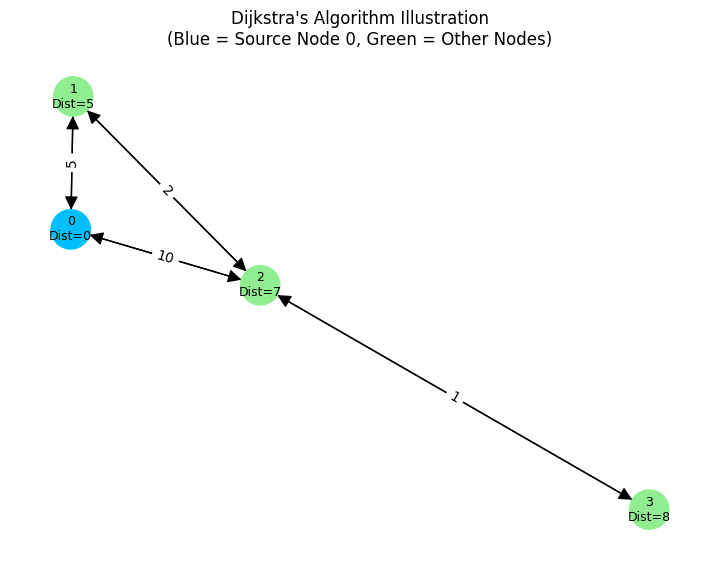

Dijkstra Distances: {0: 0, 1: 5, 2: 7, 3: 8, 4: inf}


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

distances = dij_out

G = nx.DiGraph() # Dijkstra's can be used on directed graphs
for u, neighbors in sample_adj_dij.items():
    for v, w in neighbors:
        G.add_edge(u, v, weight=w)

plt.figure(figsize=(7,5))
pos = nx.spring_layout(G, seed=15) # For consistent layout

edge_labels = nx.get_edge_attributes(G, 'weight')

node_colors = []
for node in G.nodes():
    if node == 0: # Source node
        node_colors.append("deepskyblue")
    else:
        node_colors.append("lightgreen")

nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=800, arrowsize=20)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Create labels including node ID and distance
labels = {i: f"{i}\nDist={distances[i] if distances[i]!=float('inf') else '∞'}" for i in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=9)

plt.title("Dijkstra's Algorithm Illustration\n(Blue = Source Node 0, Green = Other Nodes)")
plt.show()

print("Dijkstra Distances:", distances)

In [ ]:
mst_out = prim_mst(sample_mst_adj, 0)
print("MST Total Cost:", mst_out[0])
print("MST Edges:", mst_out[1])

MST Total Cost: 9
MST Edges: [(0, 2, 3), (2, 3, 2), (0, 1, 4)]


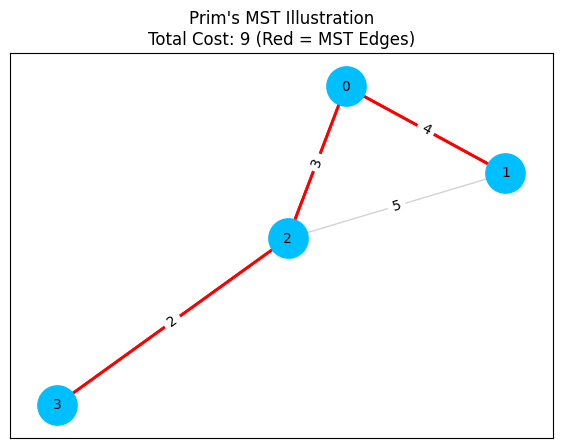

MST Total Cost: 9
MST Edges: [(0, 2, 3), (2, 3, 2), (0, 1, 4)]


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

mst_total_cost = mst_out[0]
mst_edges = mst_out[1]

G = nx.Graph() # MST is for undirected graphs
for u, neighbors in sample_mst_adj.items():
    for v, w in neighbors:
        G.add_edge(u, v, weight=w)

plt.figure(figsize=(7,5))
pos = nx.spring_layout(G, seed=20) # For consistent layout

# Draw all edges first, then highlight MST edges
nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1)

# Highlight MST edges
mst_edge_list = [(u, v) for u, v, w in mst_edges]
mst_edge_list_rev = [(v, u) for u, v, w in mst_edges]

nx.draw_networkx_edges(G, pos, edgelist=mst_edge_list + mst_edge_list_rev, edge_color='red', width=2)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='deepskyblue', node_size=800)
nx.draw_networkx_labels(G, pos, font_size=10)

# Edge labels for all edges
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

plt.title(f"Prim's MST Illustration\nTotal Cost: {mst_total_cost} (Red = MST Edges)")
plt.show()

print("MST Total Cost:", mst_total_cost)
print("MST Edges:", mst_edges)

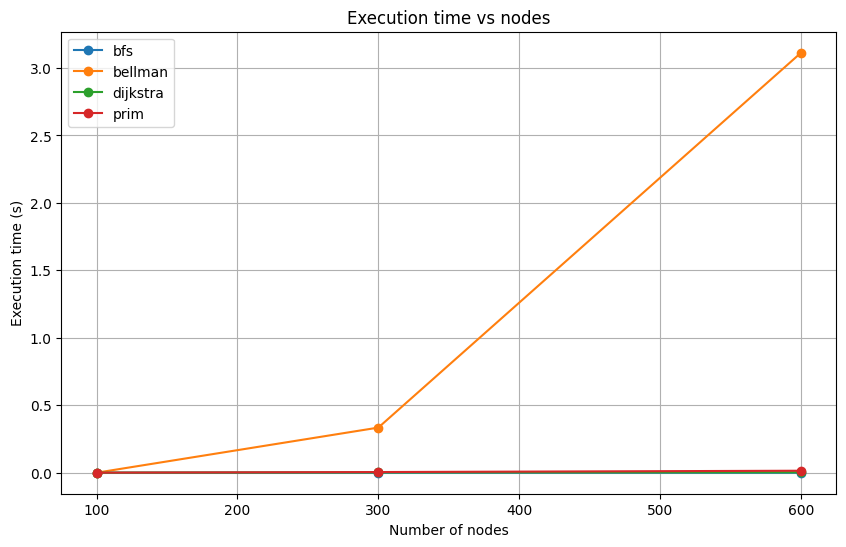

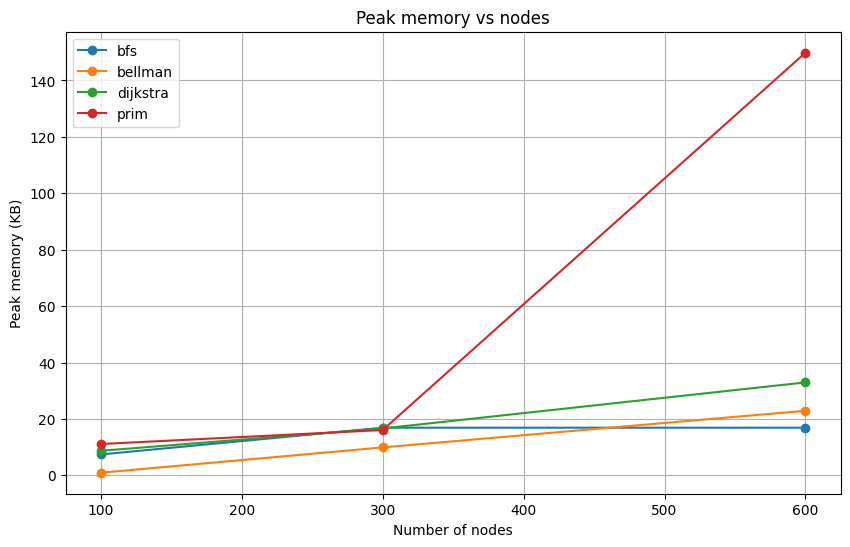

In [ ]:
sizes = [100, 300, 600]
times = {"bfs": [], "bellman": [], "dijkstra": [], "prim": []}
mems = {"bfs": [], "bellman": [], "dijkstra": [], "prim": []}

for n in sizes:
    random.seed(42)
    adj_dij, _ = generate_random_graph_adj(n, p=0.02, weight_range=(1,20), directed=False, allow_negative=False)
    adj_dij_pref = {k: [(v,w) for (v,w) in adj_dij[k]] for k in adj_dij}
    m_dij = measure(dijkstra, adj_dij_pref, 0)
    times["dijkstra"].append(m_dij["time"])
    mems["dijkstra"].append(m_dij["mem_peak_kb"])

    adj_prim, _ = generate_random_graph_adj(n, p=0.02, weight_range=(1,20), directed=False, allow_negative=False)
    m_prim = measure(prim_mst, {k: [(v,w) for (v,w) in adj_prim[k]] for k in adj_prim}, 0)
    times["prim"].append(m_prim["time"])
    mems["prim"].append(m_prim["mem_peak_kb"])

    adj_bf, edges_bf = generate_random_graph_adj(n, p=0.01, weight_range=(1,20), directed=True, allow_negative=True)
    m_bf = measure(bellman_ford, edges_bf, n, 0)
    times["bellman"].append(m_bf["time"])
    mems["bellman"].append(m_bf["mem_peak_kb"])

    nodes = n
    friend_adj = {}
    for i in range(nodes):
        friend_adj[i] = []
    for i in range(nodes):
        for _ in range(min(6, nodes-1)):
            j = random.randrange(nodes)
            if j!=i and j not in friend_adj[i]:
                friend_adj[i].append(j)
                friend_adj[j].append(i)
    user_node = 0
    m_bfs = measure(friend_suggestions_bfs, friend_adj, user_node)
    times["bfs"].append(m_bfs["time"])
    mems["bfs"].append(m_bfs["mem_peak_kb"])

plt.figure(figsize=(10,6))
for k in times:
    plt.plot(sizes, times[k], marker='o', label=k)
plt.xlabel('Number of nodes')
plt.ylabel('Execution time (s)')
plt.title('Execution time vs nodes')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
for k in mems:
    plt.plot(sizes, mems[k], marker='o', label=k)
plt.xlabel('Number of nodes')
plt.ylabel('Peak memory (KB)')
plt.title('Peak memory vs nodes')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
os.makedirs("output", exist_ok=True)
with open("output/README.md","w") as f:
    f.write("# Graph Real-World Problems\n\nThis repo contains implementations for:\n\n- Social Network Friend Suggestion (BFS)\n- Route Finding (Bellman-Ford)\n- Emergency Response (Dijkstra)\n- Network Cable Installation (Prim MST)\n\nRun the notebook cells in order to reproduce results and plots.\n")
with open("output/requirements.txt","w") as f:
    f.write("networkx\nmatplotlib\npandas\n")
results_summary = {
    "friend_suggestions_sample_output": fs_out,
    "bellman_sample": {"distances": bf_res[0], "negative_cycle": bf_res[1]},
    "dijkstra_sample_distances": dict(list(dij_res.items())[:10]),
    "prim_mst_sample_total": mst_res[0],
    "profiling": {"sizes": sizes, "times": times, "mems_kb": mems}
}
with open("output/results_summary.json","w") as f:
    json.dump(results_summary, f, indent=2)
print("Saved README.md, requirements.txt, results_summary.json in ./output/")

Saved README.md, requirements.txt, results_summary.json in ./output/


In [ ]:
with open("output/results_summary.json") as f:
    print(f.read()[:2000])

{
  "friend_suggestions_sample_output": [
    "D",
    "E",
    "F"
  ],
  "bellman_sample": {
    "distances": [
      0,
      -15,
      -8,
      -16,
      Infinity
    ],
    "negative_cycle": true
  },
  "dijkstra_sample_distances": {
    "0": 0,
    "1": 5,
    "2": 7,
    "3": 8,
    "4": Infinity
  },
  "prim_mst_sample_total": 9,
  "profiling": {
    "sizes": [
      100,
      300,
      600
    ],
    "times": {
      "bfs": [
        0.00031016599999134087,
        0.0002823560000138059,
        0.000312140999994881
      ],
      "bellman": [
        0.00012415899999496105,
        0.3345397680000133,
        3.113011658000005
      ],
      "dijkstra": [
        0.0005447270000047411,
        0.0022884530000055747,
        0.00331904300000474
      ],
      "prim": [
        0.0005369480000183557,
        0.005101292999995621,
        0.014883421000007502
      ]
    },
    "mems_kb": {
      "bfs": [
        7.3984375,
        16.890625,
        16.890625
      ],
    